In [1]:
# primary settings
state = 'AL'
district_type = 'CD'
level = 'vtd'
deviation = 0.01  # 0.10 means 10% means +/-5%
minority = 'Black'

In [2]:
filepath = 'C:\\districting-data-2020-reprojection\\'
filename = state + '_' + level + '.json'

from read import read_graph_from_json
G = read_graph_from_json( filepath + filename )
print("number of nodes, edges:",G.number_of_nodes(),G.number_of_edges())

number of nodes, edges: 1837 5221


In [3]:
from number_of_districts import number_of_districts

k = number_of_districts[state, district_type]
ideal_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes ) / k

import math
L = math.ceil(  ideal_population * (1-deviation/2) )
U = math.floor( ideal_population * (1+deviation/2) )

print("Using k, L, U =",k,L,U)

Using k, L, U = 7 714166 721342


In [4]:
# bidirected version of graph G
import networkx as nx
DG = nx.DiGraph(G)
DG._L = L
DG._U = U

In [5]:
# build optimization model to minimize inverse PP score
from district import build_single_district_mip 

m = build_single_district_mip( DG, minority=minority, mvap_excess_penalty=0.0, contiguity='cut', split_counties_limit=1 )

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-16
Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter IntFeasTol to value 1e-07


In [6]:
# solve the MISOCP
m.optimize(m._callback)

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900K, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 14191 rows, 12486 columns and 58699 nonzeros
Model fingerprint: 0xeac05322
Model has 1 quadratic constraint
Variable types: 6 continuous, 12480 integer (12480 binary)
Coefficient statistics:
  Matrix range     [3e-05, 3e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve time: 0.03s
Presolved: 14191 rows, 12486 columns, 58699 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 12483 integer (12480 binary)

Root relaxation: objective 0.000000e+00, 7999 iterations, 0.25 seconds (0.81 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth Int

In [7]:
print("The inverse Polsby-Popper score is",m.objval)
print("The Polsby-Popper score is",1.0/m.objval)

# retrieve the district and its population
district = [ i for i in G.nodes if m._x[i].x > 0.5 ] 
population = sum( G.nodes[i]["TOTPOP"] for i in district )

print("\nDistrict has this many nodes:",len(district))
print("And a population of:",population)
print("Is it connected?",nx.is_connected(G.subgraph(district)))

The inverse Polsby-Popper score is 2.5590484882153968
The Polsby-Popper score is 0.3907702431607186

District has this many nodes: 391
And a population of: 719539
Is it connected? True


In [8]:
vap = sum( DG.nodes[i]['VAP'] for i in district )
mvap = sum( DG.nodes[i]['MVAP'] for i in district )
print("The total voting age population is:",vap)
print("Among the",minority,"population, the VAP is:",mvap)
print("As a percentage, this is",round( 100 * mvap / vap, 2 ),"%")

The total voting age population is: 564112
Among the Black population, the VAP is: 282092
As a percentage, this is 50.01 %


In [9]:
# Let's draw the district on a map
from export import draw_single_district
G._state = state
G._level = level

Exporting to png...


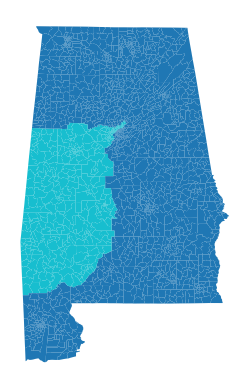

In [10]:
# State-wide view
draw_single_district( G, district, zoom=False )

Exporting to png...


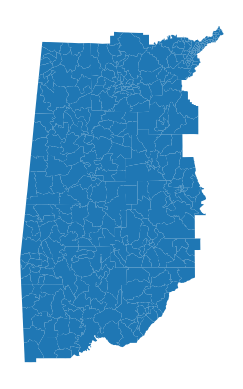

In [11]:
# District-only view
draw_single_district( G, district, zoom=True )

In [12]:
complement = [ i for i in G.nodes if i not in district ]
print("Is the complement connected?", nx.is_connected(G.subgraph(complement)))

Is the complement connected? True
